In [1]:
# -----------------------------------------------------------------------------
# Environment Setup and Imports
# -----------------------------------------------------------------------------
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import pygame

# Initialize pygame if not already initialized
if not pygame.get_init():
    pygame.init()

# Get current working directory and add configuration directory to the system path.
current_dir: str = os.getcwd()
config_dir: str = os.path.abspath(os.path.join(current_dir, "../src/environment"))
if config_dir not in sys.path:
    sys.path.append(config_dir)

# Project-specific imports
from utils import intercept_direction, can_intercept

pygame 2.6.1 (SDL 2.28.4, Python 3.9.21)
Hello from the pygame community. https://www.pygame.org/contribute.html


2025-03-20 21:59:12.221957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742518752.270607  553191 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742518752.288647  553191 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-20 21:59:12.362481: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.makedirs('../images', exist_ok=True)

In [3]:
def intercept_point_initial(chaser_pos: pygame.math.Vector2,
                            chaser_speed: float,
                            target_pos: pygame.math.Vector2,
                            target_vel: pygame.math.Vector2) -> pygame.math.Vector2:
    """
    Calcula o ponto de interceptação usando os valores iniciais.
    Se não houver solução válida, retorna target_pos.
    """
    r = target_pos - chaser_pos
    a = target_vel.dot(target_vel) - chaser_speed ** 2
    b = 2 * r.dot(target_vel)
    c = r.dot(r)
    
    t = 0.0
    if abs(a) < 1e-6:
        if abs(b) > 1e-6:
            t = -c / b
    else:
        discriminant = b**2 - 4 * a * c
        if discriminant >= 0:
            sqrt_disc = math.sqrt(discriminant)
            t1 = (-b + sqrt_disc) / (2 * a)
            t2 = (-b - sqrt_disc) / (2 * a)
            t_candidates = [t_val for t_val in (t1, t2) if t_val > 0]
            if t_candidates:
                t = min(t_candidates)
    if t <= 0:
        return target_pos
    else:
        return target_pos + target_vel * t

In [4]:
def run_simulation(chaser_pos: pygame.math.Vector2,
                   chaser_speed: float,
                   target_pos: pygame.math.Vector2,
                   point_of_interest: pygame.math.Vector2,
                   dt: float,
                   catch_threshold: float = 0.5,
                   poi_threshold: float = 0.5,
                   spiral_factor: float = 0.5,
                   target_speed: float = 1.0):
    """
    Executa a simulação passo a passo.
    
    O alvo se move em espiral até o PI: a cada passo, sua velocidade é definida pela soma
    de uma componente radial (para aproximar do PI) e de uma componente tangencial (para gerar giro).
    
    A simulação encerra quando:
      - O perseguidor alcança o alvo (distância < catch_threshold), ou
      - O alvo atinge o ponto de interesse (distância < poi_threshold).
    
    Retorna:
      - chaser_traj: trajetória do perseguidor.
      - target_traj: trajetória real do alvo.
      - intercept_flag: True se o perseguidor interceptou o alvo.
    """
    chaser_traj = []
    target_traj = []
    time_elapsed = 0.0
    intercept_flag = False

    chaser = chaser_pos.copy()
    target = target_pos.copy()

    while True:
        chaser_traj.append((chaser.x, chaser.y))
        target_traj.append((target.x, target.y))
        
        if chaser.distance_to(target) < catch_threshold:
            intercept_flag = True
            print(f"Perseguidor alcançou o alvo em {time_elapsed:.2f} s!")
            break
        if target.distance_to(point_of_interest) < poi_threshold:
            print(f"Alvo atingiu o ponto de interesse em {time_elapsed:.2f} s!")
            break

        radial_dir = point_of_interest - target
        radial_dir = radial_dir.normalize() if radial_dir.length() > 0 else pygame.math.Vector2(0, 0)
        tangential_dir = pygame.math.Vector2(-radial_dir.y, radial_dir.x)
        current_target_vel = radial_dir + spiral_factor * tangential_dir
        current_target_vel = current_target_vel.normalize() * target_speed if current_target_vel.length() > 0 else pygame.math.Vector2(0, 0)
        
        direction = intercept_direction(chaser, chaser_speed, target, current_target_vel)
        chaser += direction * chaser_speed * dt
        target += current_target_vel * dt
        
        time_elapsed += dt

    return np.array(chaser_traj), np.array(target_traj), intercept_flag

In [5]:
def run_intended_trajectory(target_pos: pygame.math.Vector2,
                             point_of_interest: pygame.math.Vector2,
                             dt: float,
                             spiral_factor: float,
                             target_speed: float,
                             poi_threshold: float = 0.5):
    """
    Simula a trajetória "pretendida" do alvo, seguindo o mesmo movimento espiral,
    até que o alvo atinja o ponto de interesse (distância < poi_threshold).
    
    Retorna a trajetória pretendida como um array de posições.
    """
    traj = []
    target = target_pos.copy()
    while target.distance_to(point_of_interest) >= poi_threshold:
        traj.append((target.x, target.y))
        radial_dir = point_of_interest - target
        radial_dir = radial_dir.normalize() if radial_dir.length() > 0 else pygame.math.Vector2(0, 0)
        tangential_dir = pygame.math.Vector2(-radial_dir.y, radial_dir.x)
        current_target_vel = radial_dir + spiral_factor * tangential_dir
        current_target_vel = current_target_vel.normalize() * target_speed if current_target_vel.length() > 0 else pygame.math.Vector2(0, 0)
        target += current_target_vel * dt
    traj.append((point_of_interest.x, point_of_interest.y))
    return np.array(traj)

Perseguidor alcançou o alvo em 221.40 s!


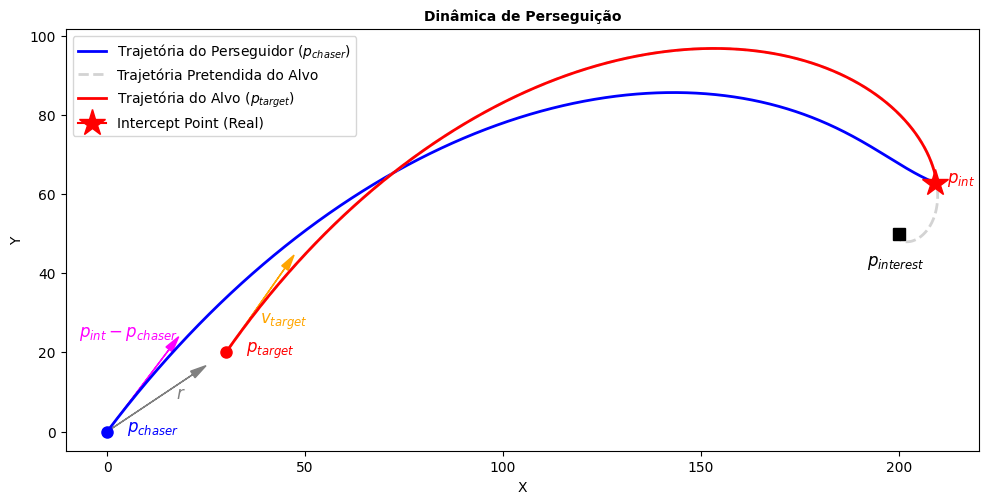

In [6]:
# Configuração do cenário
chaser_init = pygame.math.Vector2(0, 0)
target_init = pygame.math.Vector2(30, 20)
point_of_interest = pygame.math.Vector2(200, 50)

# Parâmetros de velocidade
target_speed = 1.0
chaser_speed = 1.1 * target_speed

# Parâmetros da simulação
dt = 0.1
catch_threshold = 0.5
poi_threshold = 0.5
spiral_factor = 1

# Executa a simulação principal
chaser_traj, target_traj, intercepted = run_simulation(chaser_init, chaser_speed, target_init,
                                                        point_of_interest, dt,
                                                        catch_threshold, poi_threshold,
                                                        spiral_factor, target_speed)

# Executa a simulação da trajetória pretendida do alvo até o PI
intended_traj = run_intended_trajectory(target_init, point_of_interest, dt, spiral_factor, target_speed, poi_threshold)

# Para fins de plot, o ponto de interceptação que de fato ocorreu:
if intercepted:
    p_i_actual = pygame.math.Vector2(chaser_traj[-1][0], chaser_traj[-1][1])
else:
    p_i_actual = None

# O vetor de interceptação a ser desenhado é calculado com base no intercept point
# obtido na primeira iteração (usando os valores iniciais)
p_i_initial = intercept_point_initial(chaser_init, chaser_speed, target_init,
                                      ( (point_of_interest - target_init).normalize() + spiral_factor * pygame.math.Vector2(-(point_of_interest - target_init).normalize().y, (point_of_interest - target_init).normalize().x) ).normalize() * target_speed)

# Fator de escala para os vetores
scale = 30

# Vetor r: de p_c até p_t (usando os valores iniciais)
r_vec = target_init - chaser_init
r_norm = r_vec.normalize() * scale if r_vec.length() > 0 else r_vec

# Vetor v_t: velocidade inicial do alvo conforme modelo espiral (valores iniciais)
radial_dir = point_of_interest - target_init
radial_dir = radial_dir.normalize() if radial_dir.length() > 0 else pygame.math.Vector2(0, 0)
tangential_dir = pygame.math.Vector2(-radial_dir.y, radial_dir.x)
v_t = (radial_dir + spiral_factor * tangential_dir)
v_t_norm = v_t.normalize() * scale if v_t.length() > 0 else v_t

# Vetor de interceptação: de p_c até o p_i inicial
intercept_vec = p_i_initial - chaser_init
intercept_norm = intercept_vec.normalize() * scale if intercept_vec.length() > 0 else intercept_vec

# Plotagem sem grid
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title("Dinâmica de Perseguição", fontsize=10, fontweight='bold')  
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_aspect('equal')

# Trajetória do perseguidor (azul)
ax.plot(chaser_traj[:, 0], chaser_traj[:, 1], 'b-', linewidth=2, label="Trajetória do Perseguidor ($p_{chaser}$)")
# Trajetória pretendida do alvo (espiral) em cinza claro
ax.plot(intended_traj[:, 0], intended_traj[:, 1], color='#d3d3d3', linestyle='--', linewidth=2,
        label="Trajetória Pretendida do Alvo")
# Trajetória real do alvo (vermelha)
ax.plot(target_traj[:, 0], target_traj[:, 1], 'r-', linewidth=2, label="Trajetória do Alvo ($p_{target}$)")

# Pontos:
ax.plot(chaser_init.x, chaser_init.y, 'bo', markersize=8)
ax.text(chaser_init.x + 5, chaser_init.y, "$p_{chaser}$", color='blue', fontsize=12)
ax.plot(target_init.x, target_init.y, 'ro', markersize=8)
ax.text(target_init.x + 5, target_init.y, "$p_{target}$", color='red', fontsize=12)
ax.plot(point_of_interest.x, point_of_interest.y, 'ks', markersize=8)
ax.text(point_of_interest.x - 8, point_of_interest.y - 8, "$p_{interest}$", color='black', fontsize=12)

# Se a interceptação ocorreu, marca o ponto de interceptação real
if p_i_actual is not None:
    ax.plot(p_i_actual.x, p_i_actual.y, marker='*', markersize=20,
            color='red', label="Intercept Point (Real)")
    ax.text(p_i_actual.x + 3, p_i_actual.y, "$p_{int}$", color='red', fontsize=12)
else:
    ax.plot([], [], marker='*', markersize=20, color='red', label="Ponto de Interceptação")

# Vetores (calculados a partir dos valores iniciais):
# Vetor r (de p_c até p_t)
ax.arrow(chaser_init.x, chaser_init.y, r_norm.x, r_norm.y, head_width=2, head_length=4,
         fc='gray', ec='gray', length_includes_head=True)
ax.text(chaser_init.x + r_norm.x/2 + 5, chaser_init.y + r_norm.y/2, "$r$", color='gray', fontsize=12)

# Vetor v_t (de p_t, representando a velocidade inicial do alvo)
ax.arrow(target_init.x, target_init.y, v_t_norm.x, v_t_norm.y, head_width=2, head_length=4,
         fc='orange', ec='orange', length_includes_head=True)
ax.text(target_init.x + v_t_norm.x/2, target_init.y + v_t_norm.y/2 - 5, "$v_{target}$", color='orange', fontsize=12)

# Vetor de interceptação (de p_c até p_i inicial)
ax.arrow(chaser_init.x, chaser_init.y, intercept_norm.x, intercept_norm.y, head_width=2, head_length=4, # linewidth=2,
         fc='magenta', ec='magenta', length_includes_head=True)
ax.text(chaser_init.x - intercept_norm.x/2.5, chaser_init.y + intercept_norm.y, "$p_{int}-p_{chaser}$", color='magenta', fontsize=12)

ax.legend(loc='upper left')

plt.tight_layout(rect=[0, 0.15, 1, 1])
plt.savefig(f'../images/intercept.png', format='png', bbox_inches='tight')
plt.show()
plt.close()




In [7]:
chaser_init = pygame.math.Vector2(0, 0)
target_init = pygame.math.Vector2(30, 20)
point_of_interest = pygame.math.Vector2(200, 50)

In [8]:
possible = can_intercept(chaser_init, chaser_speed, target_init, point_of_interest-target_init, point_of_interest)
print("É possível interceptar?" , possible)

É possível interceptar? False


In [9]:
pygame.quit()